In [1]:
#hide
from fastbook import *

In the previous chapter we learnt about creating custom heads and bodies for neural architectures for
different tasks in NLP,Computer vision,tabular module and collaborative filtering.We also learnt about
the steps to reduce overfitting in the model.In this chapter we will be exploring in detailed about
the training process and the optimizers mainly.

# The Training Process

Optimizers make up a very important part of the training process.In the stochastic gradient descent,
data is passed in mini-batches to the model.The difference between targets and predictions are
calculated using the loss function and then the gradients are calculated for each step which are then
used to update the weights using the following equation:-

    weight_up=weight-(lr X gradient)

In the previous chapters we have implemented this also in scratch and we also used PyTorch's nn.SGD 
class for implementing SGD.This chapter we would be building some more optimizers like SGD.If there
is any change in the training loop,we would add some callbacks to the code using fastai.Thus we would
also be learning about fastai's callback systems.

To start with we would begin with the basic SGD and then discuss further optimizers.

## Establishing a Baseline

We would be training a baseline model using basic SGD and then we would implement a model using 
fastai's default optimizer and compare both.We would be using the Imagenette data we used earlier in
the Resnet chapter.

First we build a model which would use fastai's default optimizer.We define separate functions to
create DataBlock and get dataloaders object using get_data function."get_learner" is used for creating
learner for training the model.Then we would fit our model for few epochs and at a suitable learning 
rate.

"__get_data__" function for getting dataloaders.Create DataBlock first through which we pass the 
blocks for input(Image Block) and output(CategoryBlock),splitter function for training and validation
split,get the labels using the parent folder name.We pass the url for the dataset,the presize for
resizing the image to larger size before batching and resize the size to crop the image after batching
.Thus in item_tfms resize the image to large size and in batch_tfms we pass some aug_transforms which
do random cropping of the image followed by batch normalization.Next we create the dataloaders using
the dataloaders method and a batch size of 128.

In [6]:
#Function to get dataloaders
def get_data(url, presize, resize):#url for the dataset,resize before batching,size after batching
    path = untar_data(url)#download and extract data
    return DataBlock(#Input Block,output block
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, #get image files
        splitter=GrandparentSplitter(valid_name='val'),#splitter for training,validation split
        get_y=parent_label, item_tfms=Resize(presize),#resizing to bigger size
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),#augmentation transforms
                    Normalize.from_stats(*imagenet_stats)],#Batch normalization
    ).dataloaders(path, bs=128,num_workers=0)#creating dataloaders

After defining the function to get the dataloaders we call the "get_data" function through which we 
pass the url,presizing size and the resizing size and store the dataloaders in dls.

In [7]:
#get dataloaders 
dls = get_data(URLs.IMAGENETTE_160, 160, 128)#url,presizing size,resizing size

Next we define a get_learner function to get the learner and pass any number of arguments.Through the
learner we pass the dataloaders,the model architecture,without pretraining so pretrained=False and 
accuracy as metrics and other arguments which are passed through the function.

In [8]:
#function to get the learner 
def get_learner(**kwargs):#dataloaders,model architecture,pretrained=False,accuracy as metrics
    return cnn_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

Next we get the learner by calling the get_learner function and then train the model using fastai's 
default optimizer and fit_one_cycle method for 3 epochs and a learning rate of 3 X 10^-3.

In [9]:
#training the model using fastai's default optimizer
learn = get_learner()
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.548572,1.871270,0.405605,03:09
1,1.878169,1.669986,0.455287,03:03
2,1.455472,1.165345,0.621911,03:04


We get an accuracy of 62% using fastai's default optimizer.Next we can get the learner using plain 
SGD optimizer by passing opt_func=SGD through the get_learner function.

In [10]:
#get the learner for training using SGD
learn = get_learner(opt_func=SGD)

We use fastai's learning rate finder "lr_find" to select the optimal learning rate by plotting loss vs
learning rate.

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=1.737800812406931e-05)

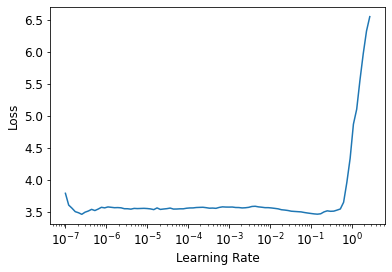

In [11]:
#Finding learning rate
learn.lr_find()

The plot shows that the loss is constant for high learning rates also and there is a sharp increase at
lr=9 X 10^-1.Thus we would be choosing a high learning rate of around 0.03 which is optimal.

Since we are already using a high learning rate to train the model.So further speeding it up is not a 
good idea.Passing momentum while training model is a good thing to do to speed up the training.Fastai 
does this by default so it has to be turned off by passing moms(momentums) as (0,-0,0).Next we train 
the model by passing the epochs,the learning rate and the momentums=0,0,0 to turn them off.

In [12]:
#training the model for 3 epochs and a faster learning rate and turning off the momentum
learn.fit_one_cycle(3, 0.03, moms=(0,0,0))

epoch,train_loss,valid_loss,accuracy,time
0,2.914951,2.051403,0.279236,02:59
1,2.392031,1.800109,0.387771,02:57
2,2.133406,1.615982,0.445860,02:58


This optimizer seems pretty slow thus we try some fast optimizers in the next part of the chapter. 

## A Generic Optimizer

To create a fast optimizer,first we build a flexible basic optimizer.We cannot build such foundation
using any other library,thus we would gradually improve the optimizer using pieces of codes known as
optimizer callbacks.These codes help in modifying the "__step__" task in an optimizer.They can be 
called using PyTorch's Optimizer class.The two main methods of stepping the gradients and zero_grad
are defined below:-
   ```python
def zero_grad(self):
    for p,*_ in self.all_params():
        p.grad.detach_()
        p.grad.zero_()

def step(self):
    for p,pg,state,hyper in self.all_params():
        for cb in self.cbs:
            state = _update(state, cb(p, **{**state, **hyper}))
        self.state[p] = state
```

We have created a SGD optimizer from scratch while training a model for MNIST dataset."Zero_grad" 
method iterates through all the parameters of the model and sets the gradients to zero.Using the 
detach method it removes any previous gradient history to save time and memory.

In the step method it loops through all the parameters first and inside the loop through all the 
callbacks to update the parameters.The update function just updates the parameters if the callbacks
return anything.Also we need to call some other functions in the Optimizer to update the parameters.
It cannot do anything on its own.Let's see how to add a callback to the Optimizer.

In the below code cell we have defined a function "__sgd_cb__" for callback it multiplies the gradient
by learning rate(-lr) and then adds it to the parameter(p.data.add_).This is one of the syntax in
PyTorch that if two parameters are passed through Tensor.add_ they are multiplied first and then 
addition occurs.

In [13]:
#callback to update the parameters
def sgd_cb(p, lr, **kwargs):#parameters,learning rate passed
    p.data.add_(-lr, p.grad.data)#lr and p.grad.data(gradient) multiplied and added to p.data

We then create an optimizer by creating a  partial function for Optimizer with cbs(callback) parameter
as the sgd_cb.After this now we can create our learner by calling get_learner function and passing the
partial function we created as the optimizer.Next we use fit method to train the model for 3 epochs 
and 0.03 learning rate.

In [14]:
#passing the callback through optimizer using partial function
opt_func = partial(Optimizer, cbs=[sgd_cb])

We get the learner and train the model.

In [15]:
#get the learner and train the model
learn = get_learner(opt_func=opt_func)#passing opt_func as the optimizer
learn.fit(3, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.689246,2.059260,0.302930,02:54
1,2.194534,1.752509,0.403567,02:59
2,1.915995,1.658461,0.441529,02:58


Though this is not giving very good accuracy but still it works.Thus we learnt here how can we define
an optimizer.Let's learn about momentum now..

## Momentum

We had mentioned about "__momentum__" in the previous chapter also.We will get into the technical
meaning later.Lets first learn about its physical meaning.In SGD we are trying to minimise the 
loss function and thus finding the optimum set of parameters using gradients.So,if we are 
supposedly standing at the top of mountain and we go down by taking small steps in the direction
of decreasing slope.Suppose ball starts rolling down on its own,it doesn't necessarily follow the
direction of gradient as it has momentum.In physics momentum is defined as the product of mass 
and velocity.So if velocity is kept constant,a ball with more momentum has more mass and is thus 
heavy will skip small holes and bumps and will reach the minimum(lowest) point of the mountain.
A light ball with less momentum on the other hand may get stuck in a narrow opening.

To apply this concept in SGD,we use a moving average while updating the weights.In normal SGD,
we update weights using the following equation:
    
weight = weight-lr*gradients

When we apply moving average here to weights it is calculated as:-
    
    Weight.avg=beta X weight.avg +(beta-1) X weight.grad
    
    new_weight=weight-lr X weight.avg
    
Beta is the parameter which indicates the magnitude of the momentum we should use.If beta becomes
0,the equation is like, "__weight_avg=weight_grad__",this is the normal SGD.In this case there is
no momentum.But as it increases and becomes close to 1,then there in momentum and the next step
depends on the average of the previous steps."Weight.avg" means that moving average is saved at 
every step.

Next we would create a set of noisy data and plot momentum and gradients together in the same
plot.We would notice how momentum changes if the gradients are changed and affected by noise.

From the plots we can observe that the gradients increase,decrease but momentum is not affected 
by noisy data.It follows the general trend.

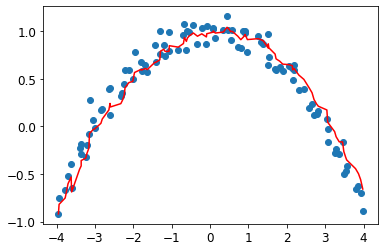

In [16]:
#Example of momentum
x = np.linspace(-4, 4, 100)#array of 100 numbers between -4 and 4(independent variable)
y = 1 - (x/3) ** 2#the dependent variable(y=1-x^2/9)quadratic relationship between both
x1 = x + np.random.randn(100) * 0.1#adding some noise
y1 = y + np.random.randn(100) * 0.1#adding some noise
plt.scatter(x1,y1)#plotting the noisy data
idx = x1.argsort()#sorting the input
beta,avg,res = 0.7,0,[]#initializing the beta,the moving average and the array for storing the
#dependent variable
for i in idx:#looping through array index
    avg = beta * avg + (1-beta) * y1[i]#calculating moving average
    res.append(avg/(1-beta**(i+1)))#the dependent variable
plt.plot(x1[idx],np.array(res), color='red');#plotting the moving average with the input

If the loss function has a deep curve then,momentum SGD works well instead of the normal SGD
which would just keep bouncing from one direction to another.While momentum SGD converges 
smoothly.As mentioned before beta indicates the momentum and lies between 0 and 1.A small beta 
means the momentum is small and the results would be similar to the actual gradients and when 
beta increases,moving average of the weights is used to update the weights and thus the next step
depends on the average.

When value of beta is close to 1,since it is acclerated so we won't know when the gradient 
changes direction or is stuck within local minima.
Whenever we test our model with some new input point which it hasn't seen before it looks for a 
point in training set which is similar to it but not identical.So it will end up at a point on 
the loss function which would be close to the minimum but not exactly a minima.So the model would
have a wide minima and nearby points in the input would have same loss.

Below code cell shows the changes in the loss as we vary the momentum that is beta.

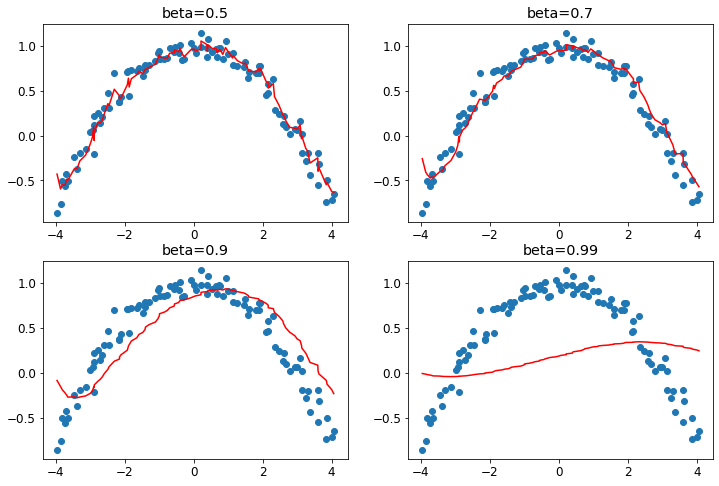

In [17]:
#Changes in loss with variation in momentum
x = np.linspace(-4, 4, 100)#array for input variable
y = 1 - (x/3) ** 2#array for dependent variable
x1 = x + np.random.randn(100) * 0.1#adding noise
y1 = y + np.random.randn(100) * 0.1#adding noise
_,axs = plt.subplots(2,2, figsize=(12,8))#axes for the different plots
betas = [0.5,0.7,0.9,0.99]#varying values for beta
idx = x1.argsort()#sorting the input values
for beta,ax in zip(betas, axs.flatten()):#looping through the beta values
    ax.scatter(x1,y1)#Plot original data for every value of beta
    avg,res = 0,[]#initialise the moving average and the array for storing averahe
    for i in idx:
        avg = beta * avg + (1-beta) * y1[i]#calculate average for input at every index
        res.append(avg)#/(1-beta**(i+1)))#store it in array
    ax.plot(x1[idx],np.array(res), color='red');#plot the average against the input
    ax.set_title(f'beta={beta}')#set the beta value as heading for every plot

Very high values of beta results in the disturbance in the gradient trend and it doesn't go in 
the right direction.0.9 is the optimal value of beta which is very often used with SGD.

fit_one_cycle method which we often use to train our model by default uses a beta value of 0.95
then changes it to 0.85 with time and then again modifies it to 0.95 by the end of the training
process.We would train our model this time with momentum combined with SGD.

To add momentum to the optimizer the moving average at every step should be stored which is done
using a callback only.This callback returns a "__dict__",which updates the optimizer state and is
passed back to the optimizer in the next step.Thus the function callback "__average_grad__" keeps
 the record of the gradient average.We pass the weight,momentum and other parameters if any are 
there.It returns the dict and keeps record of the gradient average in parameter called 
"__grad_avg__".

In [18]:
#Average_grad function for keeping record of the grad_avg
def average_grad(p, mom, grad_avg=None, **kwargs):#pass momentum,gradient through the function
    if grad_avg is None:#if grad_avg not initialized
        grad_avg = torch.zeros_like(p.grad.data)#initialize it by creating zero matrix of shape 
        #similar to the gradient matrix
    return {'grad_avg': grad_avg*mom + p.grad.data}#return the grad_avg value
                                              #grad_avg=grad_avg X momentum + gradient

To update the weight we use the momentum_step function callback through which we pass the 
gradient,learning rate and the moving gradient_average.It returns the learning rate multiplied by
gradient average and added to the parameter value.

In [19]:
#function callback for updating the parameter value
def momentum_step(p, lr, grad_avg, **kwargs): #parameter,learning rate,gradient average passed
    p.data.add_(-lr, grad_avg)#equivalent to p - lr X gradient_avg

Next we define the partial function for optimizer with callbacks to average_grad and momentum_
step with a momentum of 0.9.We name this function "opt_func".

In [20]:
opt_func = partial(Optimizer, cbs=[average_grad,momentum_step], mom=0.9)

Next we call the get_learner function and pass "opt_func" as the optimizer and get the learner.
The learner will automatically pass the momentum and learning rate so we directly train the model
using fit_one_cycle method for 3 epochs and at a learning rate of 0.03.

In [21]:
#get the learner by calling get_learner function
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.03)#train the model for 3 epochs at a learning rate of 0.03.

epoch,train_loss,valid_loss,accuracy,time
0,2.803135,4.395226,0.210701,02:58
1,2.437195,1.852835,0.360255,02:59
2,2.162518,1.804546,0.441783,02:59


We plot the hyperparameters ,learning rate and momentum against the number of epochs using the
learn.recorder.plot_sched() function as it keeps the record of how the parameters change.

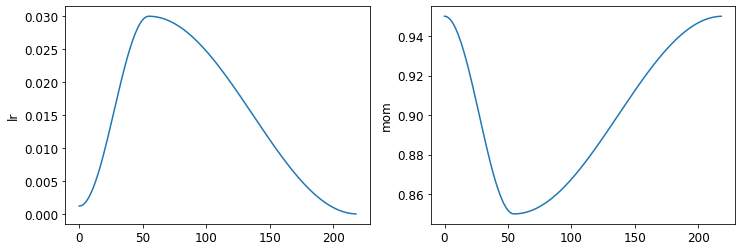

In [22]:
#plotting the learning rate and momentum with the number of epochs
learn.recorder.plot_sched()

After adding momentum to the custom optimizer the accuracy doesn't improve.So we would try some
other optimizer functions now..

## RMSProp

RMSProp is an another optimization algorithm introduced by Geoff Hilton in one of his Coursera
courses.We should be clear with SGD and SGD with momentum before understanding RMSProp.It's an 
another type of SGD and differs from it in such a way that it uses adaptive learning rate that is
different learning rate for every parameter all of which are controlled by a global learning rate
.This way,training can be much faster as instead of same learning rate for all parameters,we 
train those parameters at higher one which change a lot and those at a lower one which do not.

That is fine but how do we classify the weights as the ones which require higher learning rate 
and which don't.The gradients though can give an idea about that.If the gradient is nearly zero
for a long time means the loss is constant and the learning rate should be high.If the gradients
are changing often then they may diverge soon and therefore we should select a lower learning
rate for such parameters.If we directly take the mean of the gradients we cannot know about their
variation because average of high positive and high negative number would result in zero.So we 
would either take the mean of the absolute values or mean of the squared values and then square
root of the mean.

Then we would follow the same process to determine the moving average of the gradients but this
time squared gradients.We would calculate the moving average in the same way we did earlier using
beta which indicates momentum.The only difference would be that instead of the p.grad that is 
gradient we would be having the squared value of the gradient.Also we would update the weight by 
dividing the current gradient by the square root of the moving average.This way the effective 
learning rate is higher if the average is low and vice-versa.The equations for calculating moving
average as well as the new weights are as follows:-
    
    w_wquare_avg=(alpha X w_square_avg) + (1-alpha) X (w.grad ^2)
    
    new_weight=weight-lr X weight.grad/math.sqrt(w.average_avg+eps)

Instead of beta we have alpha here which has a default value of 0.99.The epsilon stands for 
numerical stability.We add this to the Optimizer using the function callbacks as previously we
had done.For keeping record of average_square_gradient we define the same function 
"__average_sqr_grad__" which takes parameter,momentum(sqr_mom) as arguments and calculated the 
square_avg and keeps a record of it by returning it as "__sqr_avg__" in the form of dict.

In [23]:
#function callback for calculating squared average gradient
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):#parameter,momentum,sqr_avg passed
    if sqr_avg is None: #if sqr_avg is not initialized
        sqr_avg = torch.zeros_like(p.grad.data)#initialize it by creating a zero matrix with 
        #similar shape
    return {'sqr_avg': sqr_avg*sqr_mom + p.grad.data**2}#return sqr_avg as dict

In the same way we define a callback for stepping the weights as "__rms_prop_step__".We pass the
parameter(p),the learning rate(lr),the squared average(sqr_avg),epsilon(eps) through the function
.It adds epsilon(eps) to the average(sqr_avg) and then takes square root of the number.The number
is then stored in a different variable and gradient is divided by it and result is  multiplied by
learning rate which is then added to weight.

Next we define the optimization function by passing partial function for Optimizer and callbacks
are passed as a list consisting of average_sqr_add and rms_prop_step and momentum(sqr_mom) and
epsilon(eps) values are also passed.

In [24]:
#function for callback for updating the weights
def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):#parameter,learning rate,squared
    #average,epsilon,gradient average
    denom = sqr_avg.sqrt().add_(eps)#squared average added to epsilon and square root taken
    p.data.addcdiv_(-lr, p.grad, denom)#equivalent to 
    #weight-lr X weight.grad/math.sqrt(w.average_avg+eps)

opt_func = partial(Optimizer, cbs=[average_sqr_grad,rms_prop_step],#partial function for 
                   #optimizer ,callbacks passed,momentum,epsilon values passed
                   sqr_mom=0.99, eps=1e-7)

In the similar way we get the learner by calling the function get_learner and passing opt_func as
the optimizer and then training the model for 3 epochs and the 0.003 learning rate as usual.

In [25]:
#get the learner by passing opt_func as optimizer
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.003)#training the model for 3 epochs

epoch,train_loss,valid_loss,accuracy,time
0,2.710865,2.224867,0.289936,02:56
1,2.109964,1.563029,0.501656,02:26
2,1.835967,1.455885,0.547006,02:21


The accuracy improves by 10% with RMSProp optimizer.Now we would learn about adam,fastai's 
default optimizer and how it combines RMSProp and SGD with momentum.

## Adam

Adam combines the SGD with momentum and RMSProp together.Like SGD with momentum it uses moving 
average of gradients to decide the direction of the loss function and like RMSProp divides the 
gradient by the square root of the moving average of the squared gradients to give an adaptive
learning rate as in RMSProp according to the nature of the gradients.(changing frequently or
constant).

Adam differs from RMSProp in the way moving average is computed.Takes the unbiased moving average
as:-
    
    w.avg=beta X w.avg + (1-beta) X w.grad
    
    unbiased_avg=w.avg/(1-beta^(i+1))
    
for every ith iteration.1-beta^(i+1) ensures that the unbiased average acts like gradients at 
the beginings.Since beta is less than 1 and beta^i+1 becomes very small and thus denominator is
very close to 1.Thus removing the bias from the weighed average.
So combining all the steps we would get,
     
    w.avg=beta1 X w.avg + (1-beta1) X w.grad
    
    unbias_avg=w.avg/(1-beta1^(i+1))
    
    w.sqr_avg=beta2 X w.sqr_avg + (1-beta2) X (w.grad ^ 2)
    
    new_weight=weight - (lr X unbias_avg/sqrt(w.sqr_avg + eps))
    
For RMSProp,the values of eps is 10^-8 and beta1 and beta2 are 0.9 and 0.999 respectively.

Now,fastai uses adam as the default optimizer as it speeds up the training process.We have two 
betas here.Beta1 is actually the momentum parameter passed with moms argument.The default eps 
value is 10^-5.Earlier we mentioned eps is used for numerical stability,but it is also used for 
controlling the value of the adjusted learning rate.If eps is set to 1 then the new learning rate
can never be higher than the originally passed learning rate.

In previous chapter we had also applied weight decay as a type of regularization where to prevent
overfitting weights are multiplied by a number less than 1 leading to reduction in the value.
This weight decay can be applied in different ways in different optimizers.Let's see how that 
differs in Adam and SGD.

# Decoupled Weight Decay

Previously when we had applied weight decay we had passed a value in the argument "wd" in the 
fit_one_cycle call.If we talk in mathematical terms,it is equivalent to the following equation 
when weights are updated..
     
     new_weight=weight - lr X wd X weight - lr X weight.grad

Here wd is the weight decay.Thus weight is decareased by a factor of lr X wd.It is also called 
the L2 Regularization because sum of squares of all the weights multiplied by learning rate is
added to the loss.So the gradients are updated as:-This is actually the effective gradient which 
is then put in the above equation.
    
    weight.grad+=wd X weight

So in SGD,both the above two equations are same.But this is true only for normal SGD.With other 
optimizers we studied such as SGD with momentum,RMSProp and the Adam the weight update step has
other equations also involving the gradient.

In a Research work on Decoupled Weight Decay Regularization it has been mentioned that Adam 
Optimizer and momentum with SGD use the first equation and that's why fastai uses it as default.

Optimizers play an important role in the training process.A basic training loop involves sending 
a batch of inputs to the model,loss computed using the labels and the outputs and calculating 
gradients and thus updating the weights using those gradients.This happens in order and repeated 
many times.Now most of the times we do not write the code from scratch and we happen to use 
direct modules or functions for the purpose.In that case if we want to introduce some changes in 
the training loop,then we cannot directly change the code in the library.In such conditions,
PyTorch/fastai provides some callbacks using which we can introduce any tweaks in different 
blocks.Let's learn more about callbacks...

## Callbacks

Most of the times our models face the problem of overfitting or high memory consumption and then 
we need to tweak things a little bit.Some of the changes we introduced in last few chapters are
using Mixup,fp_16 training,resetting the model after every epoch in RNN etc.We can also do some
changes in the training loop.

Let's see the basic training loop for a single epoch:-

```python
for xb,yb in dl:#looping through every batch in dataloader
    loss = loss_func(model(xb), yb)#calculate loss by passing the predictions and the targets
    loss.backward()#calculate gradient
    opt.step()#update the weights
    opt.zero_grad()#zero_grad the optimizer(to avoid adding of gradients)
```
Below figure also explains the most basic training loop for every deep learning model:-<img alt="Basic training loop" width="300" caption="Basic training loop" id="basic_loop" src="images/att_00048.png">
    

Normally to do any modifications in training loop,most of the people generally copy the code of 
the current loop and then add some code to it to change it.However it has many disadvantages...

If we change the code of the training loop then it's not compulsory that it will meet our 
requirements.Many modifications can be made to the training loop which includes thousands of 
combinations.Every training loop uses different environment,naming conventions and requires data 
to be in different formats.

The code must be added to training loop in a consistent way.Thus callback is a way to do this.A
callback is a code which we add into an another code at a particular location.Callbacks are very
often used in training loops.Previously we could insert code only at few specific places,and 
callbacks were not flexible enough.

A callback should be flexible and effecient enough that it should be able to read every line of 
code in training loop and tweak them accordingly as needed.It should be able to execute the full
training loop at the end of a batch,epoch or even if the loop terminates.Fastai provides all 
these functionalities in a single library.

Using fastai callback system we can modify any training loop an incoming user request.We do not
change the training loop though,the callbacks are added.Below figure shows some of the callbacks
<img alt="Some fastai callbacks" width="500" caption="Some fastai callbacks" id="some_cbs" src="images/att_00050.png">

Callbacks are advantageous in such a way that we can implement any functionality we require and 
add or remove anything.We need to decide the order of the list of callback functions to be passed
 to the fit function.Let's learn how do we create a Callback:-

# Creating a Callback

Whenever we want to create any callback,there are some basic events which we should know.They are
:-

1."__begin_fit__":-This is called before doing anything;

2."__begin_epoch__":-This is called at the beginning of every epoch.Used for anything to be set 
    before any epoch.

3."__begin_train__":-It is called at the beginning of any training of an epoch.

4."__begin_batch__":-Called at the beginning of the batch when just the segregation into batch 
    had happened.This is used for applying anything which is required to do for whole batch such
as changing input/output before they are supplied to model.For eg.Mixup.

5."__After_pred__":-It is called after model predicts the output.It is used to transform the 
    output before it is calculated in loss function.
    


6."__After_loss__":-It is called after the loss calculation but before backpropogation.Also used
    to add penalty,(Activation Regularization,Temporal Activation regularization)

7."__after_backward__":-Called after backpropogation but before updating the weights.
    
    

8."__after_step__":-Called after updating the parameters and before zeroing the gradients.
    
9."__after_batch__":-Called at the end of batching to do any later tasks if required before the 
    next one.
    
10."__after_train__":-Called at the end of every epoch after training process.
    
11."__begin_validate__":-Called at the beginning of the validation process of an epoch.
    
12."__After_validate__":-Called at the end of the validation phase of an epoch.
    
13."__after_epoch__":-called at the end of every epoch to do any clean up if required before next
    epoch.
    
14."__after_fit__":-called at the end of whole training phase.
    

All these options are listed as attributes under special variable known as event.Typing event 
gives us the list of all these options.

Let's look at one of the examples of model reset we had also done before in RNN and LSTMs.We had
to call the reset method before starting the training and validation phase of every epoch.Fastai
provides a ModelResetter Callback which we can use..Let's look at the source code for the same...

In [26]:
#Callback for model resetter
class ModelResetter(Callback):
    def begin_train(self):    
        self.model.reset()
    def begin_validate(self): 
        self.model.reset()

The above callback just calls the reset method before training and validation of every epoch.

Callbacks are mostly short only.Let's look at one of the callbacks which applies Regularization 
to RNNs.(Activation Regularization(AR) and Temporal Activation regularization(TAR)).

In [27]:
#Callback for RNN regularization
class RNNRegularizer(Callback):
    def __init__(self, alpha=0., beta=0.): #passing alpha and beta parameters through the 
        #callback
        self.alpha,self.beta = alpha,beta

    def after_pred(self):#called after model makes predictions
        self.raw_out,self.out = self.pred[1],self.pred[2]#three continuous predictions stored
        #in different variables
        self.learn.pred = self.pred[0]

    def after_loss(self):#called after loss calculation.To add any penalty to the loss
        if not self.training: #Check if it is in training phase.if not return 
            #else continue
            return
        if self.alpha != 0.:#check if alpha is non zero
            self.learn.loss += self.alpha * self.out[-1].float().pow(2).mean()#update the penalty
            #for loss for AR
        if self.beta != 0.:#Check if beta is non zero
            h = self.raw_out[-1]#get the current state
            if len(h)>1:
                self.learn.loss += self.beta * (h[:,1:] - h[:,:-1]#add the penalty by taking 
                                                #mean of the square of the difference between the
                                                #activations for TAR
                                               ).float().pow(2).mean()

Previously we had learnt about AR and TAR in which activations are minimized.We had used the
direct callback of RNNRegularizer which applies AR and TAR to our network.Above code shows the 
source code for that callback.The equation for AR was:-
    
``` python
loss += alpha * activations.pow(2).mean()
```
and that of TAR is as follows:-
    
``` python
loss += beta * (activations[:,1:] - activations[:,:-1]).pow(2).mean()
```

"__after_pred__" is called after model predicts the output.It is used to transform the output.So
three continuous predictions are stored in different variables which will be used next.Next,
"__after_loss__" is called after the loss calculation and before backpropogation to add some
penalty.So we add the penalty to loss in this function for AR and TAR.

In the above callback we can notice that elements of the training loop can be accessed using 
self.model and self.pred . Callback gets the attribute if there is no learner associated with it.
They can also be accessed using self.learn.model or self.learn.pred.But both of them cannot be
used for same purposes.Like for modifying values we need to use self.learn.model but for just 
reading the value self.learn or self.pred can be used.Some of the main attributes of Learner 
which can be accessed in a callback are as follows:-
    
1.__model__:the main model architecture used for training

2.__data__:the dataloaders object
    
3.__loss_func__:the loss function
    
4.__opt__:the optimizer for updating parameters
    
5.__opt_func__:optimization function for creating optimizer
    
6.__cbs__:list for the callbacks
    
7.__dl__:current dataloaders batch
    
8.__x/xb__:input from current dataloaders batch.xb generally refers to tuple and x is not tuple.
    
9.__y/yb__:output from current dataloaders batch.yb is tuple but y is not.
    
10.__pred__:predictions from last model
    
11.__loss__:last calculated loss 

12.__n_epoch__:no of epochs in the training loop
    
13.__n_iter__:no of iterations in the current dataloader batch
    
14.__epoch__:current epoch going on 
    
15.__iter__:current iteration number


Below are the attributes used by TrainEvalCallback and can be used if we don't remove the 
callback.

1."__train_iter__":Number of iterations from the start of the training process.
    
2."__pct_train__":fraction of training iterations which are over.
    
3."__training__":To test if we are in training mode or not.



We know about exceptions in Python.It is an event which can disturb the normal flow of the 
program and occurs during the execution of the code.It raises an error.Callbacks also interrupt
the training flow by raising exceptions.

### Callback Ordering and Exceptions

Some callbacks are meant for raising exceptions or to skip over a batch,an epoch or terminate 
training.One of the examples shown below is "__TerminateOnNaNCallback__" which terminates the 
training process if loss is an infinite number or a NaN.Below is the source code for the same...

In [28]:
class TerminateOnNaNCallback(Callback):
    run_before=Recorder
    def after_batch(self):#event called when batching is over
        if torch.isinf(self.loss) or torch.isnan(self.loss):#checks for nan or infinite loss
            raise CancelFitException#terminates training loop

"after_batch" is called whenever any batch training and validation is over.It checks if the loss
is infinite or a Nan.The last line then raises an exception using raise "__CancelFitException__"
which terminates training at that point only if such condition is encountered.The training loop
identifies the exception and doesn't proceed further.Some of the exceptions available are:-

1."__CancelFitException__":Skips the batch and goes to "after_batch"
    
2."__CancelEpochException__"Skips the training of the rest epoch and jumps to "after_train"

3."__CancelTrainException__"Skips the validation of the rest epoch and jumps to "after_validate"

4."__CancelValidException__"Skips the rest epoch and jumps to "after_epoch"

5."__CancelBatchException__"Terminates the training and goes to "after_fit"

Callbacks are called in order many times.Like previously in TerminateOnNaNCallback,Recorder runs
after_batch to check for the loss.run_before and run_after are the callbacks which can make sure
the order of the callbacks as required.

## Conclusion

In this chapter we studied about the different variants of SGD how we can apply SGD,momentum and
how it acclerates the training.Developing new optimizers is a wide area of research and 
continuously new optimizers are getting made.We also explored the fastai's callback systems and 
how we can tweak training loop using that.

## Questionnaire

1. What is the equation for a step of SGD, in math or code (as you prefer)?
1. What do we pass to `cnn_learner` to use a non-default optimizer?
1. What are optimizer callbacks?
1. What does `zero_grad` do in an optimizer?
1. What does `step` do in an optimizer? How is it implemented in the general optimizer?
1. Rewrite `sgd_cb` to use the `+=` operator, instead of `add_`.
1. What is "momentum"? Write out the equation.
1. What's a physical analogy for momentum? How does it apply in our model training settings?
1. What does a bigger value for momentum do to the gradients?
1. What are the default values of momentum for 1cycle training?
1. What is RMSProp? Write out the equation.
1. What do the squared values of the gradients indicate?
1. How does Adam differ from momentum and RMSProp?
1. Write out the equation for Adam.
1. Calculate the values of `unbias_avg` and `w.avg` for a few batches of dummy values.
1. What's the impact of having a high `eps` in Adam?
1. Read through the optimizer notebook in fastai's repo, and execute it.
1. In what situations do dynamic learning rate methods like Adam change the behavior of weight decay?
1. What are the four steps of a training loop?
1. Why is using callbacks better than writing a new training loop for each tweak you want to add?
1. What aspects of the design of fastai's callback system make it as flexible as copying and pasting bits of code?
1. How can you get the list of events available to you when writing a callback?
1. Write the `ModelResetter` callback (without peeking).
1. How can you access the necessary attributes of the training loop inside a callback? When can you use or not use the shortcuts that go with them?
1. How can a callback influence the control flow of the training loop.
1. Write the `TerminateOnNaN` callback (without peeking, if possible).
1. How do you make sure your callback runs after or before another callback?

# Answers:-

Ans-1 new_weight=weight-lr X weight.grad

Ans-2 "opt_func" attribute has to be passed with learner to use any other non-default optimizer.

Ans-3 To create a custom acclerated optimizer,all the optimizer modifications can be handled
using optimizer callbacks.They are small codes which can be added to the optimizer's step method
to update the parameters.

Ans-4 zero_grad loops through the parameters and sets the gradients to zero and removes previous
gradient history using the detach method.

Ans-5 Step method is mainly used for updating the parameters.It loops through the different 
callbacks and calls them to update the parameters.

Ans-6 def sgd_cb(p,lr,**kwargs):
           p.data-=lr X p.grad.data

Ans-7 momentum is a hyperparameter in an optimizer which is used for accelerating the optimizer.
It is passed as a parameter beta which is included in the equation for calculating the moving 
average of the weight gradient and use that average to update the parameters.

    weight.avg = beta * weight.avg + (1-beta) * weight.grad 
    
    new_weight = weight - lr * weight.avg
    
    Beta is between 0 and 1 and if its 0 then its plain SGD and as it increases ,the momentum 
    effect increases and optimizer becomes acclerated.
     
Ans-8 A ball with momentum when thrown from top of a mountain, doesn't exactly follow the 
direction of the gradient as it comes down.A ball with more momentum is more likely to reach the 
bottom then with the less one.It is the same case when we are training our model.An optimizer
with momentum causes us to follow the direction of the average gradient.A small momentum value
causes us to remain close to actual gradients.

Ans-9 A high beta value for momentum causes the next step to be in the direction of the average
gradient and it would stay in that direction for long unless there is a big change in the 
gradients.

Ans-10 For one cycle training in fit_one_cycle method the default value for momentum is 0.95 in 
the starting then it gradually decreases to 0.85 and then again increases to 0.95 at the end of 
training.

Ans-11 RMSProp is one of the variants of the SGD with momentum used as optimizer.The difference
here is that it uses an adaptive learning rate.Every parameter has its separate learning rate.
Instead of the moving average of the gradient value,it uses the moving average of gradients 
squared and the effective learning rate is also obtained by dividing the current gradient by the
square root of the moving average of the gradients squared + epsilon(numerical stability).

w.square_avg = alpha * w.square_avg + (1-alpha) * (w.grad ** 2)
new_w = w - lr * w.grad / math.sqrt(w.square_avg + eps)

Ans-12 The adaptive learning rates of the parameter is decided on the basis that how frequently 
the gradient for the parameter changes.If only average is taken then it may result in zero as sum
of high positives and high negatives.That's why squared values are taken.

Ans-13 Adam combines the SGD with momentum and RMSprop together.It uses the average of the 
gradients as the direction and also divide it by the square root of the moving average of the 
gradients squared to get an adaptive learning rate.Also it calculates an unbiased moving average
instead of normal one.

Ans-14 Update step for Adam

w.avg = beta1 * w.avg + (1-beta1) * w.grad #calculating moving average

unbias_avg = w.avg / (1 - (beta1**(i+1)))#unbiased moving average

w.sqr_avg = beta2 * w.sqr_avg + (1-beta2) * (w.grad ** 2)

new_w = w - lr * unbias_avg / sqrt(w.sqr_avg + eps)#updating the weight

Ans-16 Epsilon is as such used for numerical stability in RMSProp and Adam but a higher value of
eps also limits the maximum adaptive learning rate.

Ans-18 In standard SGD,weight decay and L2 regularization are equivalent however for adaptive 
learning rate algorithms like Adam,it is not.Adam introduces a small modification by decoupling
the weight decay regularization.

Ans-19 Four steps in training loop:-
1.Access the data batch wise.
2.Pass it through the model and get the outputs.
3.Calculate loss from the output predictions and targets using loss function.
4.Calculate gradient for the loss function and update the weights

Ans-20 For tweaking any training loop different things have to be kept in mind such as different
naming conventions,environments and data formats.Callback allows us to modify the training loop 
in a systematic and proper way where we can add our own code to the training loop in a consistent
and well defined manner.

Ans-21 A callback is expected to read every small information in the model.That's why it should
have full control of when to start or terminate or modify a batch,epoch or the whole training 
loop.fastai callback system provides all this functionality.

Ans-22 We need to type just a variable called event and hit tab in the Notebook to get the list 
of all the events present.

Ans-24 While creating callback we can access the attributes using self.model,self.pred.Most of 
the attributes have learner associated with them and for reading attribute values the short forms
are used.While for writing them short forms cannot be used,learner has to be used.

Ans-25 Callbacks can tell the training loop to modify,start or terminate a batch,epoch and 
training loop.It can detect any exception if it has occured and control flow exceptions can 
terminate the process and jump to next event then.

Ans-26class TerminateOnNaNCallback(Callback):
    run_before=Recorder
    def after_batch(self):
        if torch.isinf(self.loss) or torch.isnan(self.loss):
            raise CancelFitException

Ans-27 By using run_before and run_after events in callback,we can ensure the order in which the
callbacks need to be called.


### Further Research

1. Look up the "Rectified Adam" paper, implement it using the general optimizer framework, and try it out. Search for other recent optimizers that work well in practice, and pick one to implement.
1. Look at the mixed-precision callback with the documentation. Try to understand what each event and line of code does.
1. Implement your own version of ther learning rate finder from scratch. Compare it with fastai's version.
1. Look at the source code of the callbacks that ship with fastai. See if you can find one that's similar to what you're looking to do, to get some inspiration.

## Foundations of Deep Learning: Wrap up

Congratulations, you have made it to the end of the "foundations of deep learning" section of the book! You now understand how all of fastai's applications and most important architectures are built, and the recommended ways to train them—and you have all the information you need to build these from scratch. While you probably won't need to create your own training loop, or batchnorm layer, for instance, knowing what is going on behind the scenes is very helpful for debugging, profiling, and deploying your solutions.

Since you understand the foundations of fastai's applications now, be sure to spend some time digging through the source notebooks and running and experimenting with parts of them. This will give you a better idea of how everything in fastai is developed.

In the next section, we will be looking even further under the covers: we'll explore how the actual forward and backward passes of a neural network are done, and we will see what tools are at our disposal to get better performance. We will then continue with a project that brings together all the material in the book, which we will use to build a tool for interpreting convolutional neural networks. Last but not least, we'll finish by building fastai's `Learner` class from scratch.